## Problem 2 Using Machine learning


In [1]:
# ==================== SVM CLASSIFICATION ====================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the CSV file
df = pd.read_csv("cve_iot_dataset.csv")

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nClass distribution:")
print(df['IoT_class'].value_counts())
print(f"\nMissing values:")
print(df.isnull().sum())

# Preprocess the data
print("\n" + "="*50)
print("PREPROCESSING DATA")
print("="*50)

# Fill missing values
df['description'] = df['description'].fillna('')
df['vendor'] = df['vendor'].fillna('Unknown')
df['product'] = df['product'].fillna('Unknown')
df['IoT_class'] = df['IoT_class'].fillna('Other')

# Combine text features for better classification
# We'll use description + vendor + product
df['combined_text'] = df['description'] + ' ' + df['vendor'] + ' ' + df['product']

print(f"Total samples after preprocessing: {len(df)}")


Dataset loaded successfully!
Shape: (658, 5)

Columns: ['id', 'description', 'vendor', 'product', 'IoT_class']

Class distribution:
IoT_class
Other         219
PC            163
Enterprise    118
Home           71
SCADA          54
Mobile         33
Name: count, dtype: int64

Missing values:
id               0
description      0
vendor         311
product        224
IoT_class        0
dtype: int64

PREPROCESSING DATA
Total samples after preprocessing: 658


In [2]:

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['IoT_class'])

print(f"\nLabel encoding:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}: {i}")

# Split the data
print("\n" + "="*50)
print("SPLITTING DATA")
print("="*50)

X = df['combined_text']  # Using combined text features
y = df['label_encoded']

# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")



Label encoding:
  Enterprise: 0
  Home: 1
  Mobile: 2
  Other: 3
  PC: 4
  SCADA: 5

SPLITTING DATA
Training samples: 526
Testing samples: 132


In [3]:

# Feature extraction using TF-IDF
print("\n" + "="*50)
print("FEATURE EXTRACTION (TF-IDF)")
print("="*50)

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit features to avoid memory issues
    stop_words='english',
    ngram_range=(1, 2),  # Use uni-grams and bi-grams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.85  # Ignore terms that appear in more than 85% of documents
)

print("Fitting TF-IDF vectorizer...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Testing features shape: {X_test_tfidf.shape}")



FEATURE EXTRACTION (TF-IDF)
Fitting TF-IDF vectorizer...
Vocabulary size: 3567
Training features shape: (526, 3567)
Testing features shape: (132, 3567)


In [4]:

# Train SVM model
print("\n" + "="*50)
print("TRAINING SVM MODEL")
print("="*50)

# Try different SVM configurations
print("Training Linear SVM...")
linear_svm = LinearSVC(
    C=1.0,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    max_iter=2000
)

linear_svm.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_linear = linear_svm.predict(X_test_tfidf)



TRAINING SVM MODEL
Training Linear SVM...


In [5]:

# Evaluate Linear SVM
print("\n" + "="*50)
print("EVALUATION RESULTS - LINEAR SVM")
print("="*50)

accuracy_linear = accuracy_score(y_test, y_pred_linear)
print(f"Accuracy: {accuracy_linear:.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_linear, average='weighted'):.4f}")

print("\nClassification Report:")
print(classification_report(
    y_test, 
    y_pred_linear, 
    target_names=label_encoder.classes_,
    digits=4
))

# Try RBF Kernel SVM if dataset is not too large
print("\n" + "="*50)
print("TRAINING RBF KERNEL SVM")
print("="*50)

if X_train_tfidf.shape[0] < 10000:  # Only use RBF for smaller datasets
    print("Training RBF Kernel SVM (this may take a while)...")
    
    # Use a subset for hyperparameter tuning if dataset is large
    if X_train_tfidf.shape[0] > 2000:
        print("Using subset for hyperparameter tuning...")
        # Take a stratified sample
        from sklearn.model_selection import train_test_split
        X_sample, _, y_sample, _ = train_test_split(
            X_train_tfidf, y_train, train_size=2000, random_state=42, stratify=y_train
        )
    else:
        X_sample = X_train_tfidf
        y_sample = y_train
    
    # Parameter grid for GridSearch
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    }
    
    svm_rbf = SVC(kernel='rbf', class_weight='balanced', random_state=42)
    
    grid_search = GridSearchCV(
        svm_rbf, 
        param_grid, 
        cv=3, 
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_sample, y_sample)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Train with best parameters on full training set
    best_svm = grid_search.best_estimator_
    best_svm.fit(X_train_tfidf, y_train)
    
    y_pred_rbf = best_svm.predict(X_test_tfidf)
    
    print("\n" + "="*50)
    print("EVALUATION RESULTS - RBF SVM")
    print("="*50)
    
    accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
    print(f"Accuracy: {accuracy_rbf:.4f}")
    print(f"F1-Score (weighted): {f1_score(y_test, y_pred_rbf, average='weighted'):.4f}")
    
    print("\nClassification Report:")
    print(classification_report(
        y_test, 
        y_pred_rbf, 
        target_names=label_encoder.classes_,
        digits=4
    ))
    
    best_model = best_svm
else:
    print("Dataset too large for RBF SVM. Using Linear SVM as final model.")
    best_model = linear_svm



EVALUATION RESULTS - LINEAR SVM
Accuracy: 0.7197
F1-Score (weighted): 0.7171

Classification Report:
              precision    recall  f1-score   support

  Enterprise     0.8095    0.7083    0.7556        24
        Home     0.9000    0.6429    0.7500        14
      Mobile     0.5000    0.3333    0.4000         6
       Other     0.6379    0.8409    0.7255        44
          PC     0.7778    0.6364    0.7000        33
       SCADA     0.7500    0.8182    0.7826        11

    accuracy                         0.7197       132
   macro avg     0.7292    0.6633    0.6856       132
weighted avg     0.7350    0.7197    0.7171       132


TRAINING RBF KERNEL SVM
Training RBF Kernel SVM (this may take a while)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters: {'C': 10, 'gamma': 'scale'}
Best cross-validation score: 0.5870

EVALUATION RESULTS - RBF SVM
Accuracy: 0.6894
F1-Score (weighted): 0.6811

Classification Report:
              precision    recall  f1-


VISUALIZING RESULTS


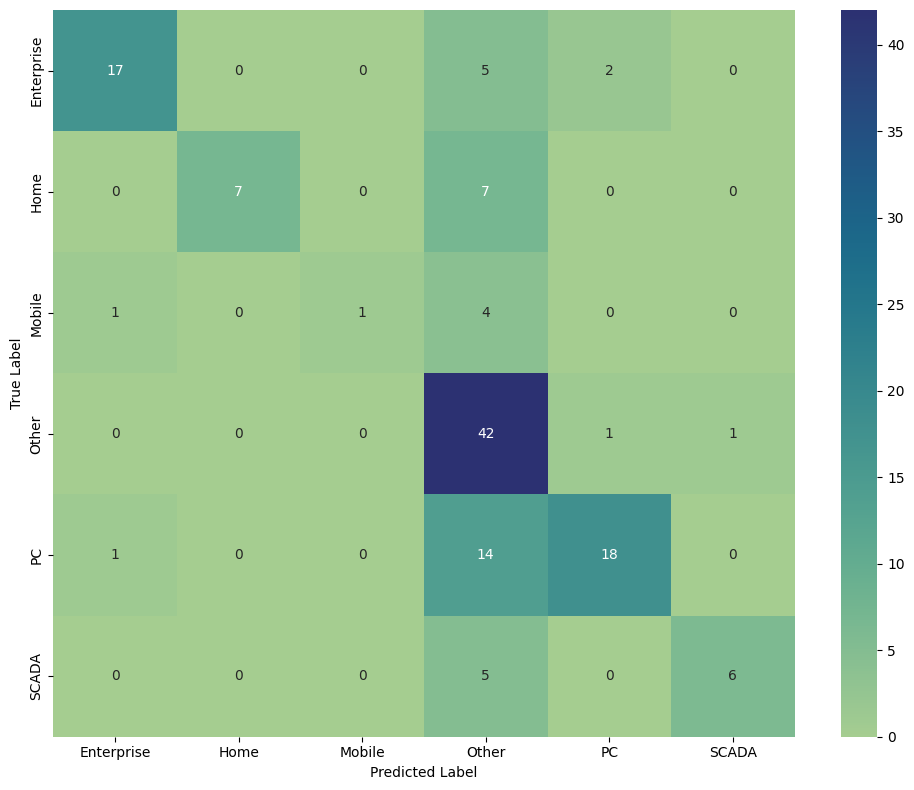

In [6]:

# Visualize results
print("\n" + "="*50)
print("VISUALIZING RESULTS")
print("="*50)

# Confusion Matrix
plt.figure(figsize=(10, 8))
if 'y_pred_rbf' in locals():
    cm = confusion_matrix(y_test, y_pred_rbf)
else:
    cm = confusion_matrix(y_test, y_pred_linear)

sns.heatmap(
    cm, 
    annot=True, 
    fmt='d',
    cmap='crest',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)

#plt.title('Confusion Matrix - SVM Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [7]:

# Feature importance (for Linear SVM)
print("\n" + "="*50)
print("TOP IMPORTANT FEATURES PER CLASS")
print("="*50)

if hasattr(best_model, 'coef_'):
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    
    for i, class_name in enumerate(label_encoder.classes_):
        coef = best_model.coef_[i]
        top_indices = np.argsort(coef)[-10:][::-1]  # Top 10 features
        
        print(f"\n{class_name} - Most important features:")
        for idx in top_indices:
            if coef[idx] > 0:  # Only show positive coefficients
                print(f"  {feature_names[idx]}: {coef[idx]:.4f}")

# Cross-validation for robustness check
print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS")
print("="*50)

cv_scores = cross_val_score(
    linear_svm, 
    X_train_tfidf, 
    y_train, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



TOP IMPORTANT FEATURES PER CLASS

CROSS-VALIDATION RESULTS
Cross-validation scores: [0.66981132 0.52380952 0.66666667 0.63809524 0.6952381 ]
Mean CV accuracy: 0.6387 (+/- 0.1205)


In [8]:

# Test on some random samples
print("\n" + "="*50)
print("TESTING ON RANDOM SAMPLES")
print("="*50)



TESTING ON RANDOM SAMPLES


In [9]:

# Get some random test samples
np.random.seed(42)
test_indices = np.random.choice(len(X_test), min(5, len(X_test)), replace=False)

print("\nSample predictions:")
for idx in test_indices:
    actual_text = X_test.iloc[idx][:200] + "..." if len(X_test.iloc[idx]) > 200 else X_test.iloc[idx]
    actual_label = label_encoder.inverse_transform([y_test.iloc[idx]])[0]
    
    if 'y_pred_rbf' in locals():
        pred_label = label_encoder.inverse_transform([y_pred_rbf[idx]])[0]
    else:
        pred_label = label_encoder.inverse_transform([y_pred_linear[idx]])[0]
    
    print(f"\nSample {idx}:")
    print(f"  Text: {actual_text}")
    print(f"  Actual: {actual_label}")
    print(f"  Predicted: {pred_label}")
    print(f"  Correct: {'Yes' if actual_label == pred_label else '✗'}")




Sample predictions:

Sample 56:
  Text: Improper access control vulnerability in FirmwareUpgrade in QSAN Storage Manager allows remote attackers to reboot and discontinue the device. The referred vulnerability has been solved with the updat...
  Actual: Enterprise
  Predicted: Enterprise
  Correct: Yes

Sample 83:
  Text: Windows Update Medic Service Elevation of Privilege Vulnerability Microsoft Windows 10 Version 20H2
  Actual: PC
  Predicted: PC
  Correct: Yes

Sample 19:
  Text: An exploitable vulnerability exists in the user photo update functionality of Circle with Disney running firmware 2.0.1. A repeated set of specially crafted API calls can cause the device to corrupt e...
  Actual: Other
  Predicted: Other
  Correct: Yes

Sample 31:
  Text: A vulnerability in the logic that handles access control to one of the hardware components in Cisco's proprietary Secure Boot implementation could allow an authenticated, local attacker to write a mod...
  Actual: Enterprise
  Predicted:

In [10]:
# Save the model and vectorizer
print("\n" + "="*50)
print("SAVING MODEL")
print("="*50)

import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save model and vectorizer
joblib.dump(best_model, 'models/svm_iot_classifier.pkl')
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')

print("Model saved to 'models/' directory:")
print("  - svm_iot_classifier.pkl")
print("  - tfidf_vectorizer.pkl")
print("  - label_encoder.pkl")

# Function to predict new CVEs
def predict_cve_iot_class(description, vendor="", product=""):
    """Predict IoT class for a new CVE"""
    combined_text = f"{description} {vendor} {product}"
    
    # Load models
    vectorizer = joblib.load('models/tfidf_vectorizer.pkl')
    model = joblib.load('models/svm_iot_classifier.pkl')
    encoder = joblib.load('models/label_encoder.pkl')
    
    # Transform and predict
    text_tfidf = vectorizer.transform([combined_text])
    prediction = model.predict(text_tfidf)
    predicted_class = encoder.inverse_transform(prediction)[0]
    
    # Get probabilities if available
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(text_tfidf)[0]
        prob_dict = {encoder.inverse_transform([i])[0]: prob for i, prob in enumerate(probabilities)}
        return predicted_class, prob_dict
    else:
        return predicted_class, None

print("\n" + "="*50)
print("PREDICTION FUNCTION READY")
print("="*50)
print("\nYou can use predict_cve_iot_class(description, vendor, product) to classify new CVEs")


SAVING MODEL
Model saved to 'models/' directory:
  - svm_iot_classifier.pkl
  - tfidf_vectorizer.pkl
  - label_encoder.pkl

PREDICTION FUNCTION READY

You can use predict_cve_iot_class(description, vendor, product) to classify new CVEs
